# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Initializations" data-toc-modified-id="Initializations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initializations</a></div>

In [145]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.datasets import mnist

# Utility Functions

In [131]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# Initializations

In [147]:
(X_train, y_train), (X_test, y_test) = mnist.load_data('/tmp/mnist.npz')

11476992/11490434 [============================>.] - ETA: 0s

In [149]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [150]:
X = X_train
y = y_train

In [166]:
def get_weights(*dims):
    return np.random.randn(*dims)

hidden_dim = 100
model = Sequential()
model.add(Dense(hidden_dim, input_shape=(X.shape[1],), name='L0'))
model.add(Activation('sigmoid', name='A0'))
model.add(Dense(hidden_dim, name='L1'))
model.add(Activation('sigmoid', name='A1'))
model.add(Dense(hidden_dim, name='L2'))
model.add(Activation('sigmoid', name='A2'))
model.add(Dense(hidden_dim, name='L3'))
model.add(Activation('sigmoid', name='A3'))
model.add(Dense(hidden_dim, name='L4'))
model.add(Activation('sigmoid', name='A4'))
model.add(Dense(y.shape[1], name='L5'))
model.add(Activation('softmax', name='A5'))

model.get_layer('L0').set_weights([get_weights(X.shape[1], hidden_dim), np.zeros(hidden_dim)])
for i in range(1, 5):
    model.get_layer('L'+str(i)).set_weights([get_weights(hidden_dim, hidden_dim), np.zeros(hidden_dim)])
model.get_layer('L5').set_weights([get_weights(hidden_dim, y.shape[1]), np.zeros(y.shape[1])])
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=1, epochs=3)
plot_loss_accuracy(history)

Epoch 1/3
53728/60000 [=========================>....] - ETA: 0s - loss: 1.0886 - acc: 0.7016

KeyboardInterrupt: 

Layer 0 sums mean: 0.443032, std: 11.971065
Layer 1 sums mean: 2.183070, std: 7.524998
Layer 2 sums mean: -0.026683, std: 7.956020
Layer 3 sums mean: 1.157606, std: 6.261279
Layer 4 sums mean: -0.439937, std: 6.994987
Layer 5 sums mean: -1.574549, std: 3.069464


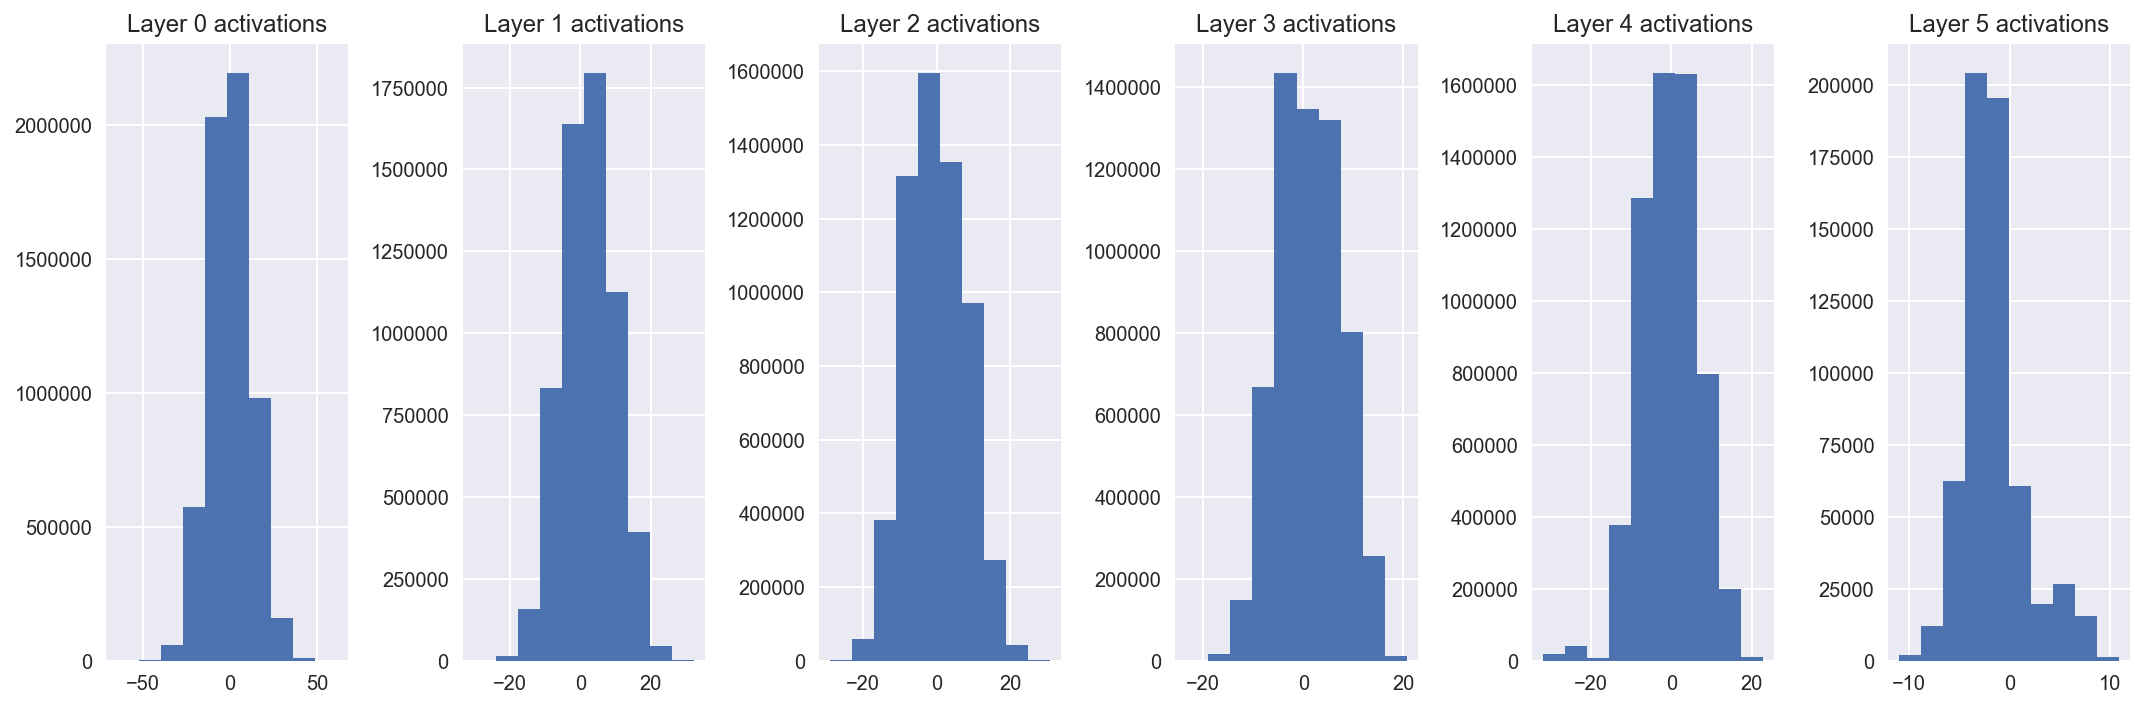

In [164]:
plt.figure(figsize=(15, 5))

for i in range(6):
    ax = plt.subplot(1, 6, i+1)
    
    inp = model.layers[0].input
    out = model.get_layer('L'+str(i)).output
    func = K.function([inp], [out])
    activations = func([X])[0].ravel()
    print('Layer %d sums mean: %f, std: %f' % (i, activations.mean(), activations.std()))
    
    plt.hist(activations)
    plt.title('Layer %d activations' % i)

plt.tight_layout()

Layer 0 activations mean: 0.505100, std: 0.467033
Layer 1 activations mean: 0.601240, std: 0.439220
Layer 2 activations mean: 0.479890, std: 0.456002
Layer 3 activations mean: 0.553016, std: 0.441983
Layer 4 activations mean: 0.485326, std: 0.444986
Layer 5 activations mean: 0.100000, std: 0.279295


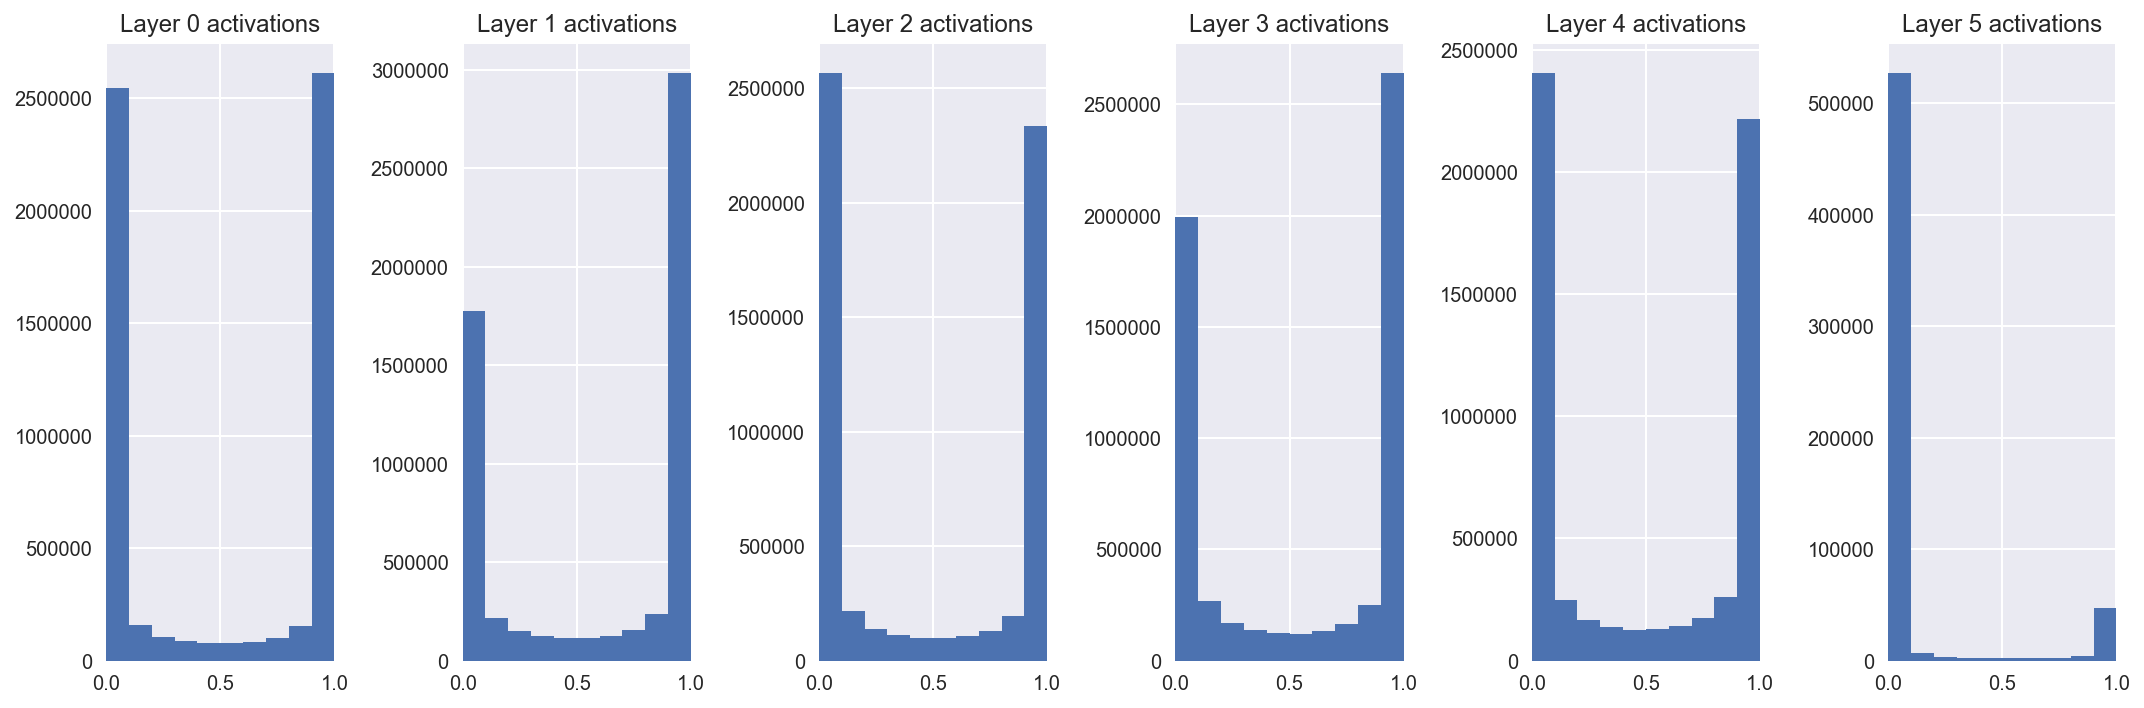

In [165]:
plt.figure(figsize=(15, 5))

for i in range(6):
    ax = plt.subplot(1, 6, i+1)
    
    inp = model.layers[0].input
    out = model.get_layer('A'+str(i)).output
    func = K.function([inp], [out])
    activations = func([X])[0].ravel()
    print('Layer %d activations mean: %f, std: %f' % (i, activations.mean(), activations.std()))
    
    plt.hist(activations)
    plt.title('Layer %d activations' % i)
    plt.xlim((0, 1))

plt.tight_layout()

(array([ 34.,   7.,   2.,   7.,   1.,   1.,   3.,   2.,   5.,  38.]),
 array([  1.27185595e-10,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

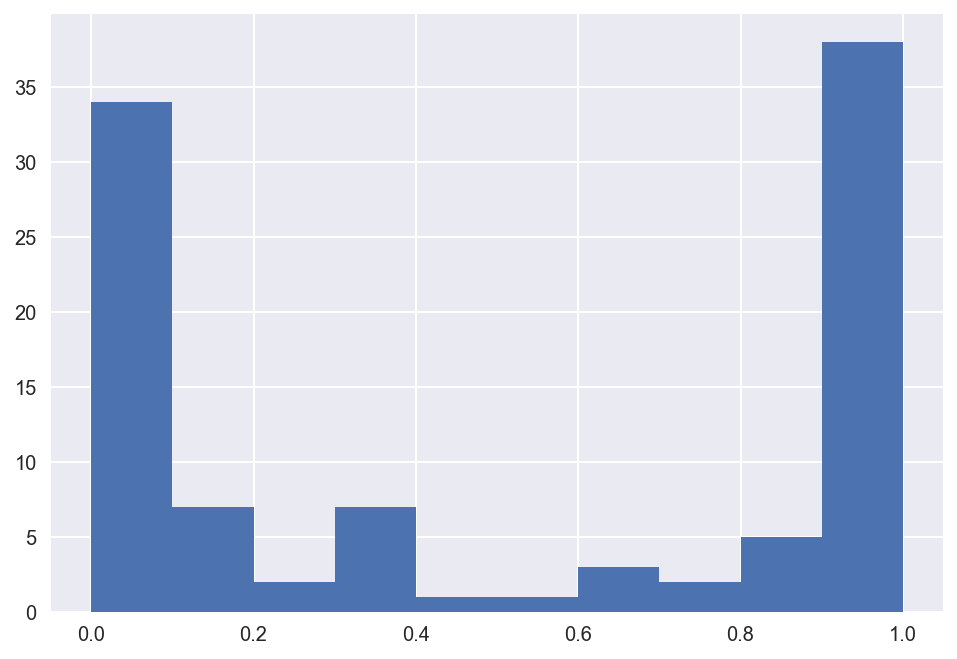

In [127]:
inp = model.layers[0].input
out = model.layers[1].output
func = K.function([inp], [out])
plt.hist(func([X])[0][0])

(array([  5.,   1.,  12.,  18.,  33.,  43.,  46.,  24.,  16.,   2.]),
 array([-2.99976683, -2.48068471, -1.96160259, -1.44252048, -0.92343836,
        -0.40435624,  0.11472588,  0.63380799,  1.15289011,  1.67197223,
         2.19105434]),
 <a list of 10 Patch objects>)

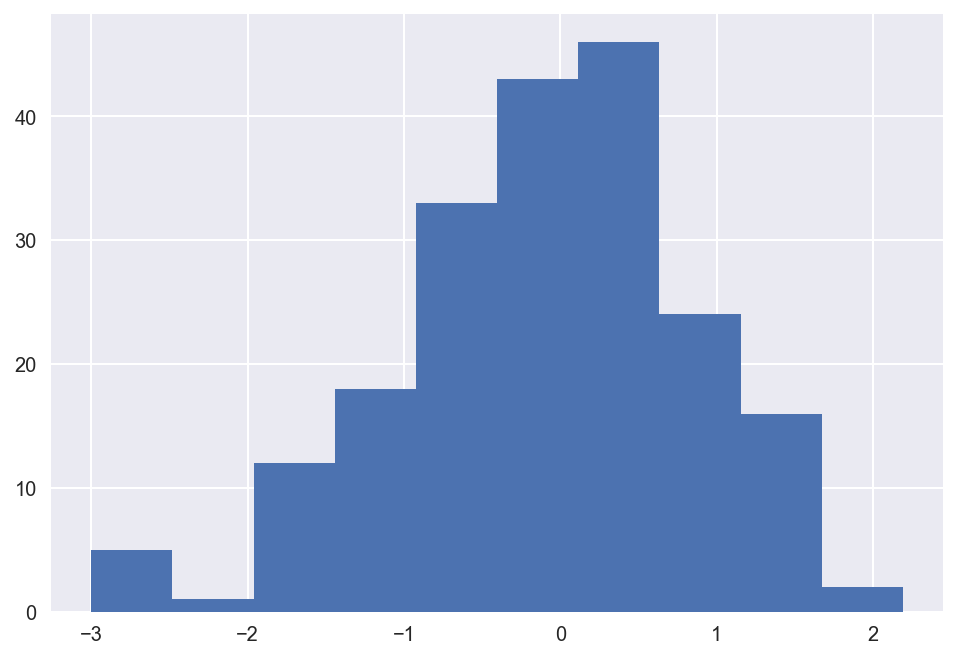

In [122]:
plt.hist(model.get_layer('L0').get_weights()[0].ravel())